# Create the dataset required for SLICE

## Unpack the polygons for France data

In [5]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

path_gpkg = "./france/PARCELLES_GRAPHIQUES.gpkg"

# Load the data
data = gpd.read_file(path_gpkg)

## Sample Polygons to create the dataset

### Choice 1: Randomly sample points from the data
**Warning**: This method will require almost the whole france planet mosiacs which could end up in TBs

In [ ]:
"""
points = data.sample(10000)
"""

### Choice 2: Select points from an ROI that has diverse plots
Randomly select 10000 points from data and save them to data/france/points.gpkg

In [ ]:
# ROI of sampled points precise repetability
roi = Polygon([
            [-0.7155534667066932, 43.39057963239615],
            [-0.7155534667066932, 43.156608691390645],
            [0.34359722909410806, 43.156608691390645],
            [0.34359722909410806, 43.39057963239615]
])
 
data = data[data.within(roi)]
sampled = data.sample(10000)

# Save the sampled points for training and testing
sampled.to_file("data/france/sampled.gpkg", driver="GPKG")

## Visualize Data

<Axes: >

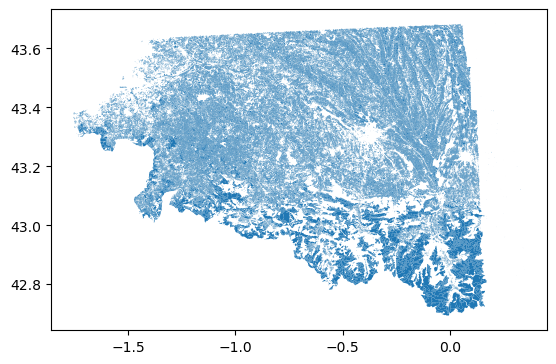

In [50]:
data.plot()

<Axes: >

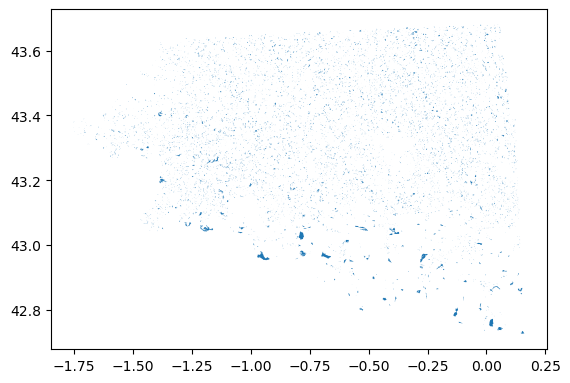

In [72]:
sampled.plot()

<Axes: >

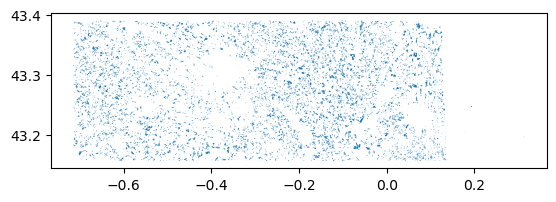

In [3]:
sampled.plot()

## Extract images

In [1]:
import os
import shutil
import tensorflow as tf
from pyunpack import Archive
import csv

BASE_DIR = "france/"

path = BASE_DIR + "gz_files/"
tf_out_path = BASE_DIR + "tf_files/"

if os.path.exists(tf_out_path):
    print("Removing Existing Directory.....")
    shutil.rmtree(tf_out_path)

print("Creating TFRECORD Exctract Directory.....")
os.makedirs(tf_out_path)
    
gz_files = os.listdir(path)

for i in gz_files:
    Archive(path+i).extractall(tf_out_path)

print(">>>>>>>>>> Extraction Complete <<<<<<<<<<<<")
    
img_out_path = BASE_DIR + "images/"
if os.path.exists(img_out_path):
    print("Removing Existing Image Directory.....")
    shutil.rmtree(img_out_path)

print("Creating IMAGE Exctract Directory.....")
os.makedirs(img_out_path)

tf_files = [tf_out_path + f for f in os.listdir(tf_out_path)]

2023-05-12 11:26:56.775618: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Removing Existing Directory.....
Creating TFRECORD Exctract Directory.....
>>>>>>>>>> Extraction Complete <<<<<<<<<<<<
Removing Existing Image Directory.....
Creating IMAGE Exctract Directory.....


In [28]:
options = tf.compat.v1.python_io.TFRecordOptions(tf.compat.v1.python_io.TFRecordCompressionType.NONE)
idx = 0

for tf_file in tf_files:
    iterator = tf.compat.v1.python_io.tf_record_iterator(tf_file, options=options)
    satellite_features = ['B1', 'B2', 'B3']
    
    n = 0
    iter = 10
    csv_file = tf_out_path  + "/img_csv.csv"
    csv_file_keys = ['Parcel_id', 'max_lat', 'max_lon', 'min_lat', 'min_lon']
    with open(csv_file, 'w') as f_csv:
        csv_writer = csv.writer(f_csv)
        csv_writer.writerow(csv_file_keys)
    
    while iter > 0:
        with open(csv_file, 'a') as f_csv:
            csv_writer = csv.writer(f_csv)
            try:
                record_str = next(iterator)
                ex = tf.train.Example.FromString(record_str)
                #print(ex.features)
                min_lon = min(ex.features.feature['longitude'].float_list.value) 
                max_lon = max(ex.features.feature['longitude'].float_list.value) 
                min_lat = min(ex.features.feature['latitude'].float_list.value) 
                max_lat = max(ex.features.feature['latitude'].float_list.value) 
                idx = idx + 1#int(ex.features.feature['Parcel_id'].float_list.value[0])
                features = []
                for satellite_feature in satellite_features:
                    feature = (ex.features.feature[satellite_feature].float_list.value)
                    feature = np.array(feature)
                    feature = feature.reshape((224, 224, 1))
                    features.append(feature)

                csv_writer.writerow([idx, max_lat*10000, max_lon*10000, min_lat*10000, min_lon*10000])
                image = np.concatenate(features, axis=2)

                if idx != -1:
                    jpeg_path = tf_out_path + '/' + str(idx) + '.jpeg'
                    
                    imageio.imwrite(jpeg_path, image)
                n += 1
                if n%10==0:
                    print("       Processed " + str(n) + " records in " + f)
            except Exception as e:
                iter -= 1
                print(e)
                print(">>>>>> Processed " + str(n) + " records in " + f)

NotFoundError: france/tf_files/ps_france_21-00000.tfrecord; No such file or directory

In [46]:
options = tf.compat.v1.python_io.TFRecordOptions(tf.compat.v1.python_io.TFRecordCompressionType.NONE)
idx = 0

tf_file = tf_files[0]
    
iterator = tf.compat.v1.python_io.tf_record_iterator(tf_file, options=options)
satellite_features = ['B3', 'B2', 'B1']

n = 0
iter = 10
csv_file = tf_out_path  + "/img_csv.csv"
csv_file_keys = ['Parcel_id', 'max_lat', 'max_lon', 'min_lat', 'min_lon']
with open(csv_file, 'w') as f_csv:
    csv_writer = csv.writer(f_csv)
    csv_writer.writerow(csv_file_keys)

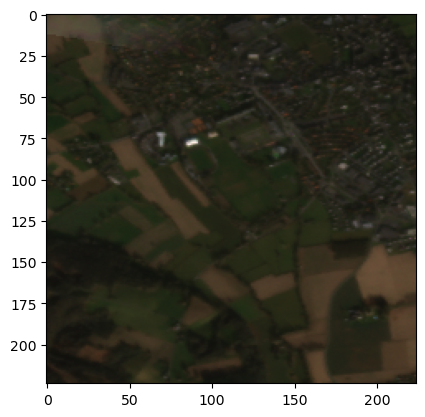

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# for i in range(50):
record_str = next(iterator)
ex = tf.train.Example.FromString(record_str)

min_lon = min(ex.features.feature['longitude'].float_list.value) 
max_lon = max(ex.features.feature['longitude'].float_list.value) 
min_lat = min(ex.features.feature['latitude'].float_list.value) 
max_lat = max(ex.features.feature['latitude'].float_list.value) 


features = []
for satellite_feature in satellite_features:
    feature = (ex.features.feature[satellite_feature].float_list.value)
    feature = np.array(feature)
    feature = feature.reshape((224, 224, 1))
    # feature = np.flip(feature, axis=0)
    features.append(feature)
    
image = np.concatenate(features, axis=2)
plt.imshow(image/np.max(image))


In [66]:
min_lon = min(ex.features.feature['longitude'].float_list.value) 
max_lon = max(ex.features.feature['longitude'].float_list.value) 
min_lat = min(ex.features.feature['latitude'].float_list.value) 
max_lat = max(ex.features.feature['latitude'].float_list.value)

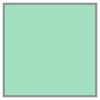

In [67]:
roi = Polygon([
    [min_lon, min_lat],
    [min_lon, max_lat],
    [max_lon, max_lat],
    [max_lon, min_lat],
])
roi

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

path_gpkg = "./france/refined.gpkg"

# Load the data
data = gpd.read_file(path_gpkg)

In [68]:
p1 = data[data.within(roi)]
p1

,ID_PARCEL,CODE_GROUP,geometry
123354,6976741,18,"MULTIPOLYGON (((-0.63297 43.17641, -0.63326 43..."
123355,10936490,11,"MULTIPOLYGON (((-0.63271 43.17557, -0.63280 43..."
123420,13309019,2,"MULTIPOLYGON (((-0.63495 43.18290, -0.63485 43..."
123471,7072379,11,"MULTIPOLYGON (((-0.62726 43.17095, -0.62713 43..."
123493,20912897,18,"MULTIPOLYGON (((-0.62573 43.19036, -0.62576 43..."
...,...,...,...
129554,20898276,5,"MULTIPOLYGON (((-0.62166 43.18867, -0.62130 43..."
129555,20898275,5,"MULTIPOLYGON (((-0.62262 43.18964, -0.62243 43..."
129556,20912931,5,"MULTIPOLYGON (((-0.62087 43.18888, -0.62024 43..."
129557,20912930,5,"MULTIPOLYGON (((-0.62003 43.18918, -0.61990 43..."


In [69]:
p1.to_file("france/p2.gpkg", driver="GPKG")

In [70]:
plt.imsave('france/images/p2.png', image/np.max(image))